# CO2 Emissions Analysis and Prediction

This notebook aims to analyze and predict CO2 emissions from various sources. Using historical data, I will:
- Understand the patterns of CO2 emissions.
- Build predictive models to forecast future emissions.
- Evaluate model performance and identify key features contributing to emissions.

The dataset contains information on CO2 emissions from various sources such as cement, coal, gas, oil, and flaring, across different countries and years.




---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Grampers\\Desktop\\CO2Oracle'

---

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/Co2Emissions.csv")
  )

print(df.shape)
df.head(3)

(63104, 10)


,Country,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,Afghanistan,1750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Ordinal encoding for categorical variables
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),  # Replace with your actual categorical variables

        # Smart correlated feature selection based on Spearman correlation
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                               method="spearman",
                                                               threshold=0.6,
                                                               selection_method="variance")),
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def PipelineReg(model):
    pipeline_base = Pipeline([
        # Step 1: Impute missing values
        ("imputer", SimpleImputer(strategy='mean')),  # Impute NaN values
        
        # Step 2: Scale the features
        ("scaler", StandardScaler()),
        
        # Step 3: Feature selection based on model's importance
        ("feat_selection", SelectFromModel(model)),
        
        # Step 4: Model fitting
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineReg(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## 2. Data Preprocessing

To ensure the dataset is ready for modeling, I will perform the following steps:
- Handle missing values by imputing them.
- Engineer new features to capture temporal patterns and interactions between different emission sources.


In [8]:
from sklearn.impute import SimpleImputer

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Impute missing values with the mean for numeric columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Drop rows with missing values in non-numeric columns
df = df.dropna(subset=non_numeric_cols)

# Feature engineering
df['Total_Lag1'] = df.groupby('Country')['Total'].shift(1)
df['Total_Lag2'] = df.groupby('Country')['Total'].shift(2)
df['Total_Lag3'] = df.groupby('Country')['Total'].shift(3)
df['Total_Rolling_Mean'] = df.groupby('Country')['Total'].rolling(window=3).mean().reset_index(level=0, drop=True)
df['Total_Rolling_Std'] = df.groupby('Country')['Total'].rolling(window=3).std().reset_index(level=0, drop=True)
df['Cumulative_Total'] = df.groupby('Country')['Total'].cumsum()
df['Coal_Gas_Interaction'] = df['Coal'] * df['Gas']
df['Oil_Flaring_Interaction'] = df['Oil'] * df['Flaring']
df['Year_on_Year_Change'] = df.groupby('Country')['Total'].pct_change(periods=12)
df['Coal_Percentage'] = df['Coal'] / df['Total']
df['Gas_Percentage'] = df['Gas'] / df['Total']
df['Oil_Percentage'] = df['Oil'] / df['Total']
df['Flaring_Percentage'] = df['Flaring'] / df['Total']

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values again if needed
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print("Shape after feature engineering and imputing missing values:", df.shape)



Shape after feature engineering and imputing missing values: (63104, 23)


## 3. Modeling

We will build several regression models to predict changes in CO2 emissions. The target variable is `CO2_Target`, which indicates whether emissions increased or decreased. We will use GridSearchCV to optimize the hyperparameters of these models.


In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define the target variable
df['CO2_Change'] = df.groupby('Country')['Total'].pct_change()
df['CO2_Target'] = (df['CO2_Change'] > 0).astype(int)

# Drop rows with missing CO2_Target
df = df.dropna(subset=['CO2_Target'])

# Split data into features and target variable
X = df.drop(['CO2_Target', 'CO2_Change', 'Country'], axis=1)
y = df['CO2_Target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models and their hyperparameters

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Define regression models
models_quick_search = {
    "Ridge": Ridge(random_state=0),
    "ElasticNet": ElasticNet(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0)
}



params_quick_search = {
    "Ridge": {},
    "ElasticNet": {},
    "RandomForestRegressor": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "GradientBoostingRegressor": {},
    "AdaBoostRegressor": {},
}

# Perform GridSearchCV for each model

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for Ridge 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ElasticNet 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Get Grid Search results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                   estimator min_score mean_score max_score std_score
6               XGBRegressor  0.845493   0.860076   0.87423   0.01006
3      RandomForestRegressor  0.823425   0.829797  0.837725  0.004656
2      DecisionTreeRegressor  0.619969   0.660991  0.679557  0.021164
4  GradientBoostingRegressor  0.594036   0.621467  0.645314  0.020878
5          AdaBoostRegressor  0.539732   0.575378  0.602851  0.026353
0                      Ridge  0.543567   0.561379  0.573785  0.010628
1                 ElasticNet -0.000312  -0.000128 -0.000003  0.000132


## Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.
- Define model and parameters, for Extensive Search


In [13]:
models_search = {
    "XGBRegressor":XGBRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBRegressor":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}


### Extensive GridSearch CV - Binary Classifier

In [14]:
from sklearn.metrics import make_scorer, r2_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(r2_score),
           n_jobs=-1, cv=5)




Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check Results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 


,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
1,XGBRegressor,0.830251,0.845761,0.859651,0.010964,0.1,10
2,XGBRegressor,0.775797,0.787438,0.797438,0.007851,0.1,None
0,XGBRegressor,0.664295,0.67904,0.698613,0.011461,0.1,3
4,XGBRegressor,0.549941,0.567771,0.585841,0.012566,0.01,10
5,XGBRegressor,0.525041,0.538366,0.553447,0.011109,0.01,None
3,XGBRegressor,0.51449,0.52684,0.541058,0.010337,0.01,3
7,XGBRegressor,0.112127,0.114982,0.118144,0.002379,0.001,10
8,XGBRegressor,0.109617,0.111633,0.114324,0.002054,0.001,None
6,XGBRegressor,0.108076,0.109814,0.11204,0.001677,0.001,3


Get best model name programmatically

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBRegressor'

Parameters for best model

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 10}

Define the best reg pipeline

In [18]:

pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

## Assess feature importance

In [19]:
X_train.head(3)

,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita,Total_Lag1,...,Total_Rolling_Mean,Total_Rolling_Std,Cumulative_Total,Coal_Gas_Interaction,Oil_Flaring_Interaction,Year_on_Year_Change,Coal_Percentage,Gas_Percentage,Oil_Percentage,Flaring_Percentage
21736,1998.0,6.244973,0.000000,5.583936,0.000000,0.661037,0.000000,10.951389,0.333693,6.204804,...,5.972809,0.437077,128.095939,0.000000,0.000000,1.060813,0.0,0.0,0.894149,0.0
54270,1892.0,0.000000,73.968916,55.760624,23.504285,4.330443,1.712695,10.951389,4.413363,0.000000,...,0.000000,0.000000,0.000000,1738.586512,95.500926,NaN,NaN,NaN,NaN,NaN
8450,1768.0,0.000000,73.968916,55.760624,23.504285,4.330443,1.712695,10.951389,4.413363,0.000000,...,0.000000,0.000000,0.000000,1738.586512,95.500926,NaN,NaN,NaN,NaN,NaN


- With the current model, we can assess with .features_importances_

* These are the 4 most important features in descending order. The model was trained on them: 
['Total_Rolling_Std', 'Total', 'Total_Lag1', 'Year_on_Year_Change']


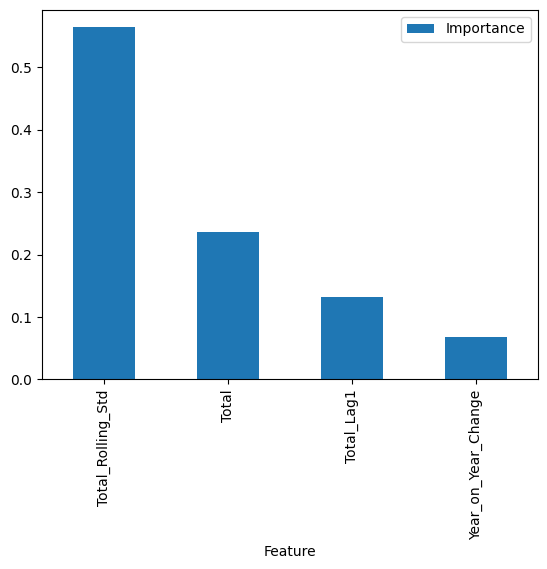

In [20]:
import matplotlib.pyplot as plt

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_reg['feat_selection'].get_support()],
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [21]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with metrics defined at ML business case

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Function to evaluate the performance of a regression model.

    Parameters:
    X_train (DataFrame): Training features
    y_train (Series): Training target variable
    X_test (DataFrame): Testing features
    y_test (Series): Testing target variable
    pipeline (Pipeline): The trained regression model pipeline

    Returns:
    dict: A dictionary containing performance metrics for both training and testing sets.
    """
    
    # Predict on training and testing sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics for training data
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    
    # Calculate metrics for testing data
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    
    # Print or return the performance metrics
    performance_metrics = {
        "Training R2": train_r2,
        "Training MAE": train_mae,
        "Training MSE": train_mse,
        "Training RMSE": train_rmse,
        "Testing R2": test_r2,
        "Testing MAE": test_mae,
        "Testing MSE": test_mse,
        "Testing RMSE": test_rmse,
    }
    
    return performance_metrics

# Example usage
metrics = reg_performance(X_train=X_train, y_train=y_train,
                          X_test=X_test, y_test=y_test,
                          pipeline=pipeline_reg)
print(metrics)


{'Training R2': 0.9137428402900696, 'Training MAE': 0.05669465381347692, 'Training MSE': 0.01543102222707392, 'Training RMSE': 0.1242216656911101, 'Testing R2': 0.8308442831039429, 'Testing MAE': 0.07587636341660374, 'Testing MSE': 0.0302607875168382, 'Testing RMSE': 0.17395628047540623}


# Step 3: Refit the Machine Learning Pipeline with Selected Features
### Refit Pipeline with Selected Features
- Objective: Refit the machine learning pipeline using only the most important features identified during the feature selection process. This step ensures that the model is more efficient without sacrificing performance, as it uses only the most predictive features.

- Theory: Ideally, a pipeline trained with only the most relevant features should perform comparably to one trained with all features, but with the added benefit of reduced complexity and potentially better generalization.

In [23]:
best_features

['Total_Rolling_Std', 'Total', 'Total_Lag1', 'Year_on_Year_Change']

New Pipeline for DataCleaning And FeatureEngineering

In [24]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])),


        # I don't need SmartCorrelatedSelection
    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling
- Function for Pipeline optmisation

In [25]:
# Pipeline Optmization: Model
def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

Split Train Test Set, considering only with best features

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['CO2_Target'], axis=1),
    df['CO2_Target'],
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50483, 24) (50483,) (12621, 24) (12621,)


I filter only the most important variables

In [78]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(50483, 3) (50483,) (12621, 3) (12621,)


,Total_Rolling_Std,Total_Lag1,Year_on_Year_Change
21736,0.437077,6.204804,1.060813
54270,0.000000,0.000000,NaN
8450,0.000000,0.000000,NaN


## Grid Search CV: Sklearn
- Using the most suitable model from the last section and its best hyperparameter configuration.

- I are using the same model from the last GridCV search

In [79]:
models_search

{'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)}

And the best parameters from the last GridCV search

In [80]:
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 10}

I need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [88]:
params_search = {'XGBRegressor':  {
    'model__learning_rate': [0.1],   # the value should be in []
    'model__max_depth': [10]},  # the value should be in []
    'model__reg_lambda': [0, 0.01, 0.1, 1.0],
}
params_search

{'XGBRegressor': {'model__learning_rate': [0.1], 'model__max_depth': [10]},
 'model__reg_lambda': [0, 0.01, 0.1, 1.0]}

GridSearch CV

In [89]:
from sklearn.metrics import make_scorer, r2_score

# Assuming models_search and params_search are already defined for regression models
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)

# Fit the model with R2 score as the scoring metric
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(r2_score),
                 n_jobs=-1, cv=7)



Running GridSearchCV for XGBRegressor 

Fitting 7 folds for each of 1 candidates, totalling 7 fits


Check results

In [90]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,XGBRegressor,0.602088,0.613905,0.623462,0.00662,0.1,10


Define the best reg pipeline

In [91]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

In [92]:
# Fit the pipeline on the training data
pipeline_reg.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = pipeline_reg.predict(X_train)
y_test_pred = pipeline_reg.predict(X_test)

# Evaluate the model performance on the training set
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

print("Training Results:")
print(f"Training R²: {train_r2}")
print(f"Training MAE: {train_mae}")
print(f"Training MSE: {train_mse}")
print(f"Training RMSE: {train_rmse}")

# Evaluate the model performance on the test set
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nTesting Results:")
print(f"Testing R²: {test_r2}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MSE: {test_mse}")
print(f"Testing RMSE: {test_rmse}")



Training Results:
Training R²: 0.7944784164428711
Training MAE: 0.09332390484838218
Training MSE: 0.036766893857197176
Training RMSE: 0.19174695266730363

Testing Results:
Testing R²: 0.6127581596374512
Testing MAE: 0.12930289030690273
Testing MSE: 0.06927490033310499
Testing RMSE: 0.263201254429201


Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['Total_Lag1', 'Year_on_Year_Change', 'Total_Rolling_Std']


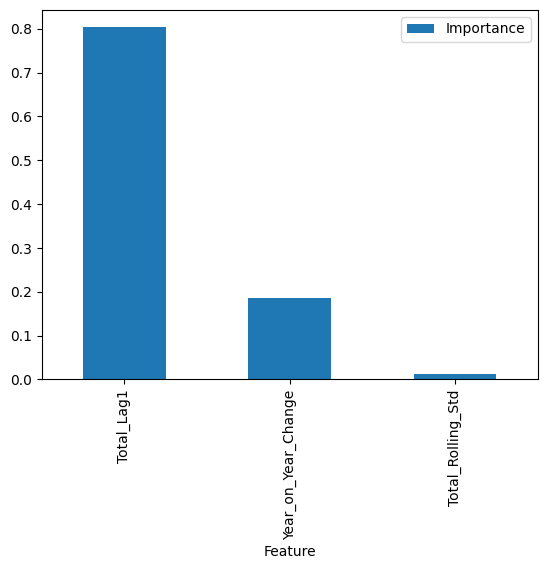

In [48]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets
- Evaluation: We cross-check with metrics defined in the ML business case.


In [49]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Function to evaluate the performance of a regression model.

    Parameters:
    X_train (DataFrame): Training features
    y_train (Series): Training target variable
    X_test (DataFrame): Testing features
    y_test (Series): Testing target variable
    pipeline (Pipeline): The trained regression model pipeline

    Returns:
    dict: A dictionary containing performance metrics for both training and testing sets.
    """
    
    # Predict on training and testing sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics for training data
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    
    # Calculate metrics for testing data
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    
    # Print or return the performance metrics
    performance_metrics = {
        "Training R2": train_r2,
        "Training MAE": train_mae,
        "Training MSE": train_mse,
        "Training RMSE": train_rmse,
        "Testing R2": test_r2,
        "Testing MAE": test_mae,
        "Testing MSE": test_mse,
        "Testing RMSE": test_rmse,
    }
    
    return performance_metrics

# Example usage
metrics = reg_performance(X_train=X_train, y_train=y_train,
                          X_test=X_test, y_test=y_test,
                          pipeline=pipeline_reg)
print(metrics)



{'Training R2': 0.8080683910618536, 'Training MAE': 36.88061398454921, 'Training MSE': 129102.2470431034, 'Training RMSE': 359.3080113817439, 'Testing R2': 0.7593278931864925, 'Testing MAE': 38.02479652659169, 'Testing MSE': 168572.35354449542, 'Testing RMSE': 410.57563681311564}


In [50]:
# Assuming `pipeline_reg` is your fitted regression model pipeline
evaluation_results = reg_performance(X_train=X_train, y_train=y_train,
                                     X_test=X_test, y_test=y_test,
                                     pipeline=pipeline_reg)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

Training R2: 0.8080683910618536
Training MAE: 36.88061398454921
Training MSE: 129102.2470431034
Training RMSE: 359.3080113817439
Testing R2: 0.7593278931864925
Testing MAE: 38.02479652659169
Testing MSE: 168572.35354449542
Testing RMSE: 410.57563681311564


## Varification

In [53]:
reg_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_reg)


{'Training R2': 0.8080683910618536,
 'Training MAE': 36.88061398454921,
 'Training MSE': 129102.2470431034,
 'Training RMSE': 359.3080113817439,
 'Testing R2': 0.7593278931864925,
 'Testing MAE': 38.02479652659169,
 'Testing MSE': 168572.35354449542,
 'Testing RMSE': 410.57563681311564}

In [54]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def reg_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Check results

### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

class ExtensiveHyperparameterSearch(BaseEstimator, TransformerMixin):
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=0, scoring=None):
        for key in self.models.keys():
            print(f"Running GridSearchCV for {key}")
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def best_estimator_(self):
        best_score = -float('inf')
        best_model = None
        for key in self.grid_searches:
            if self.grid_searches[key].best_score_ > best_score:
                best_score = self.grid_searches[key].best_score_
                best_model = self.grid_searches[key].best_estimator_
        return best_model

print(f"Best model from GridSearchCV: {best_model}")



Best model from GridSearchCV: XGBRegressor


Extensive GridSearch CV - Binary Classifier

In [94]:
from scipy.stats import uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define the models and hyperparameters for RandomizedSearchCV
models_random_search = {
    'ridge': Ridge(),
    'rf': RandomForestRegressor(),
    'gbr': GradientBoostingRegressor(),
    'xgbr': XGBRegressor(random_state=0)
}

params_random_search = {
    'ridge': {
        'alpha': uniform(loc=0, scale=10)
    },
    'rf': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'gbr': {
        'n_estimators': [100, 200, 500],
        'learning_rate': uniform(loc=0.01, scale=0.19),
        'max_depth': [3, 5, 10]
    },
    'xgbr': {
        'learning_rate': uniform(loc=0.01, scale=0.19),
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 10],
        'subsample': uniform(loc=0.5, scale=0.5)
    }
}


Check results

In [95]:
from sklearn.model_selection import RandomizedSearchCV
class ExtensiveHyperparameterSearch:
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.random_searches = {}

    def fit(self, X, y, cv=3, n_iter=50, n_jobs=-1, verbose=1, scoring=None):
        for key in self.models.keys():
            print(f"Running RandomizedSearchCV for {key}")
            model = self.models[key]
            params = self.params[key]
            rs = RandomizedSearchCV(model, params, cv=cv, n_iter=n_iter, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            rs.fit(X, y)
            self.random_searches[key] = rs

    def best_estimator_(self):
        best_score = -float('inf')
        best_model = None
        best_model_name = None
        for key in self.random_searches:
            if self.random_searches[key].best_score_ > best_score:
                best_score = self.random_searches[key].best_score_
                best_model = self.random_searches[key].best_estimator_
                best_model_name = key
        return best_model, best_model_name



Best model from GridSearchCV: Ridge(alpha=0.1)

Parameters for best model

Define the best clf pipeline

In [96]:
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

## Assess feature importance

* With the current model, we can assess with `.features_importances_`

## Evaluate Pipeline on Train and Test Sets

In [102]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def reg_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [103]:
def reg_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [104]:
best_features

Index(['Total_Rolling_Std', 'Total_Lag1', 'Year_on_Year_Change'], dtype='object')

New Pipeline for DataCleaning And FeatureEngineering

In [105]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Country'])), 


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [106]:
# Pipeline Optmization: Model
def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! I know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Total'], axis=1),
    df['Total'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)




(50483, 24) (50483,) (12621, 24) (12621,)


We filter only the most important variables

In [108]:
best_features = ['Total_Rolling_Std', 'Total_Lag1', 'Year_on_Year_Change']

X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(50483, 3) (50483,) (12621, 3) (12621,)


,Total_Rolling_Std,Total_Lag1,Year_on_Year_Change
26254,0.0,0.0,-1.0
29205,0.0,0.0,NaN
31860,0.0,0.0,NaN


## Handle Target Imbalance

Use SMOTE to balance Train Set target

Check Train Set Target distribution after SMOTE

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [109]:
models_search   # XGBRegressor

{'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)}

And the best parameters from the last GridCV search 

In [110]:
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 10}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [112]:
params_search = {
    'XGBRegressor': {
        'model__learning_rate': [0.1],   # the value should be in []
        'model__max_depth': [10],  # the value should be in []
        'model__reg_lambda': [0, 0.01, 0.1, 1.0],
    },
}


GridSearch CV

In [113]:
from sklearn.metrics import recall_score
# Define the models_search variable
models_search = {
    'XGBRegressor': XGBRegressor()
}

# Define the params_search variable
params_search = {
    'XGBRegressor': {
        'model__learning_rate': [0.1],   # the value should be in []
        'model__max_depth': [10],  # the value should be in []
        'model__reg_lambda': [0, 0.01, 0.1, 1.0],
    },
}


# Create the HyperparameterOptimizationSearch object
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)

# Fit the quick_search object
search.fit(X_train, y_train,
           scoring='neg_mean_squared_error',  # Use appropriate scoring for regression
           n_jobs=1,  # Run single-threaded to avoid parallel processing issues
           cv=5)



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [116]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='neg_mean_squared_error')
grid_search_summary 

ValueError: No objects to concatenate

Define the best reg pipeline

In [117]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['Total_Rolling_Std', 'Year_on_Year_Change', 'Total_Lag1']


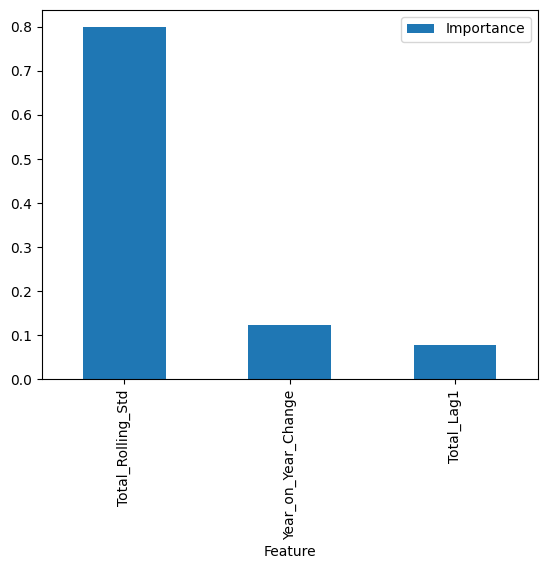

In [118]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

Evaluation: I cross-check with metrics defined in the ML business case.
 

In [119]:
if best_model in grid_search_pipelines:
    pipeline_reg = grid_search_pipelines[best_model].best_estimator_
else:
    # Handle the case when the key does not exist
    pipeline_reg = None  # Replace None with the appropriate value or code


# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [120]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_co2/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [121]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50483, 3) (50483,) (12621, 3) (12621,)


In [122]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [123]:
print(X_train.shape)
X_train.head()

(50483, 3)


,Total_Rolling_Std,Total_Lag1,Year_on_Year_Change
26254,0.000000,0.000000,-1.000000
29205,0.000000,0.000000,NaN
31860,0.000000,0.000000,NaN
20362,0.000000,0.000000,NaN
52709,0.123563,2.560779,0.637531


In [124]:
y_train

26254     0.000000
29205     0.000000
31860     0.000000
20362     0.000000
52709     2.531527
           ...    
45891     3.827889
52416    23.058224
42613     0.000000
43567     0.000000
2732      0.000000
Name: Total, Length: 50483, dtype: float64

In [125]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [126]:
print(X_test.shape)
X_test.head()

(12621, 3)


,Total_Rolling_Std,Total_Lag1,Year_on_Year_Change
38063,1.295475,12.512992,1.172565
45946,1.447570,4.684538,-0.908430
56597,0.000000,0.000000,NaN
26116,0.000000,0.000000,NaN
50017,9.606418,56.448232,-0.160871


In [127]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [128]:
y_test

38063    11.521173
45946     3.572952
56597     0.000000
26116     0.000000
50017    39.984648
           ...    
19591     0.000000
25326     0.000000
58233     0.000000
296       0.000000
4567      3.121306
Name: Total, Length: 12621, dtype: float64

In [129]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [134]:
# Define the variable "pipeline_data_cleaning_feat_eng" before using it
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()

# Now you can use the variable "pipeline_data_cleaning_feat_eng"
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Country']))])

In [135]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/reg_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_co2/v1/reg_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [136]:
pipeline_reg

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

In [137]:
joblib.dump(value=pipeline_reg ,
            filename=f"{file_path}/reg_pipeline_model.pkl")

['outputs/ml_pipeline/predict_co2/v1/reg_pipeline_model.pkl']

## Feature Importance plot

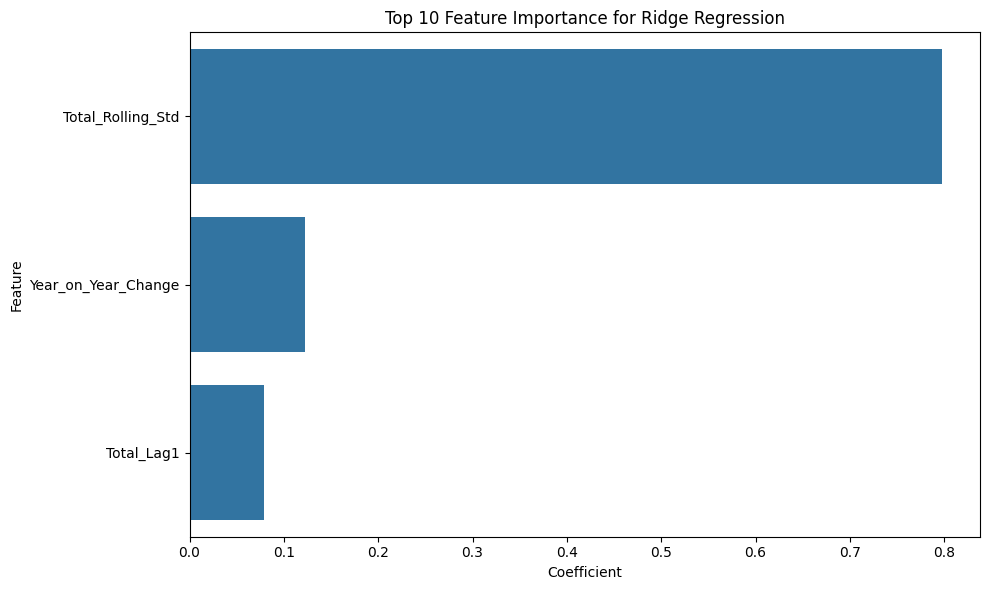

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_feature_importance is already defined
# and contains 'Feature' and 'Coefficient' columns

# Define the file path
file_path = 'outputs/ml_pipeline'  # Replace with your actual directory

# Sort the DataFrame by 'Coefficient' and get the top 10 features
df_top_features = df_feature_importance.nlargest(10, 'Coefficient')

# Truncate long feature names for better display
df_top_features['Feature'] = df_top_features['Feature'].apply(lambda x: x if len(x) <= 20 else x[:17] + '...')

# Plot using seaborn
plt.figure(figsize=(10, 6))  # Decrease the figure height if needed
sns.barplot(x='Coefficient', y='Feature', data=df_top_features)
plt.title('Top 10 Feature Importance for Ridge Regression')
plt.tight_layout()  # Adjust layout to fit everything in the figure

# Save the plot as a PNG file
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

# Show the plot
plt.show()









In [142]:
if 'Importance' in df_feature_importance.columns:
    df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
    # Recompute df_feature_importance DataFrame or use the correct column name
    pass


---